In [1]:
comment = 'stdX_bn_shuffle_adam_abc'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd#
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time

In [3]:
from Code.Models.c7o2h10_model import DeepPotential, train, normalize, backtransform
from Code.DataGeneration.saver import create_path

In [4]:
data_path = './Dataset/c7o2h10_X.npy'
label_path = './Dataset/c7o2h10_Y.npy'
train_ids_path = './Dataset/iso17/train_ids.txt'
test_ids_path = './Dataset/iso17/validation_ids.txt'
model_path = './ModelCheckpoints/c7o2h10/'
model_path = './ModelCheckpoints/c7o2h10/{}/'.format(comment)

In [5]:
use_cuda = torch.cuda.is_available()
print('use cuda:  ', use_cuda)

use cuda:   True


# Read the Data

In [6]:
train_ids = (np.loadtxt(train_ids_path) - 1).astype(int).tolist()
test_ids = (np.loadtxt(test_ids_path) - 1).astype(int).tolist()

In [7]:
X_npy = np.load(data_path)
Y_npy = np.load(label_path) * -1

## Normalize Y Data

In [8]:
Y_npy, Y_min, Y_max = normalize(Y_npy)
X_npy.shape

(404000, 19, 72)

### Standardize X Data

In [9]:
for column in range(X_npy.shape[-1]):
    col_mean = X_npy[:, :, column].mean()
    col_std = X_npy[:, :, column].std()
    X_npy[:, :, column] = (X_npy[:, :, column] - col_mean) / col_std

In [10]:
X_npy[:, :, 0].mean()#, X_npy.std(axis=2)

-8.620739233346562e-15

### Split into test and train

In [11]:
X_train_npy, X_test_npy = X_npy[train_ids], X_npy[test_ids]
Y_train_npy, Y_test_npy = Y_npy[train_ids], Y_npy[test_ids]

In [12]:
X_train = Variable(torch.Tensor(X_train_npy))
Y_train = Variable(torch.Tensor(Y_train_npy), requires_grad=False)
X_test = Variable(torch.Tensor(X_test_npy))
Y_test = Variable(torch.Tensor(Y_test_npy), requires_grad=False)

## Test Model

0:	test scoore:     0.2479		train scoore:     0.1990
1:	test scoore:     0.2406		train scoore:     0.2415
2:	test scoore:     0.2751		train scoore:     0.2052
3:	test scoore:     0.2100		train scoore:     0.1987
4:	test scoore:     0.2201		train scoore:     0.1880
5:	test scoore:     0.1910		train scoore:     0.1780
6:	test scoore:     0.1962		train scoore:     0.1650
7:	test scoore:     0.2233		train scoore:     0.2257
8:	test scoore:     0.2011		train scoore:     0.1739
9:	test scoore:     0.1961		train scoore:     0.1724
10:	test scoore:     0.1781		train scoore:     0.1514
11:	test scoore:     0.1760		train scoore:     0.1570
12:	test scoore:     0.2009		train scoore:     0.1668
13:	test scoore:     0.1841		train scoore:     0.1507
14:	test scoore:     0.1752		train scoore:     0.1568
15:	test scoore:     0.1735		train scoore:     0.1390
16:	test scoore:     0.2025		train scoore:     0.1787
17:	test scoore:     0.1961		train scoore:     0.1610
18:	test scoore:     0.1969		train sco

151:	test scoore:     0.1597		train scoore:     0.1125
152:	test scoore:     0.1565		train scoore:     0.1108
153:	test scoore:     0.1585		train scoore:     0.1132
154:	test scoore:     0.1582		train scoore:     0.1142
155:	test scoore:     0.1672		train scoore:     0.1222
156:	test scoore:     0.1592		train scoore:     0.1108
157:	test scoore:     0.1577		train scoore:     0.1173
158:	test scoore:     0.1575		train scoore:     0.1101
159:	test scoore:     0.1570		train scoore:     0.1122
160:	test scoore:     0.1560		train scoore:     0.1094
161:	test scoore:     0.1590		train scoore:     0.1142
162:	test scoore:     0.1592		train scoore:     0.1146
163:	test scoore:     0.1547		train scoore:     0.1091
164:	test scoore:     0.1598		train scoore:     0.1146
165:	test scoore:     0.1575		train scoore:     0.1133
166:	test scoore:     0.1587		train scoore:     0.1115
167:	test scoore:     0.1555		train scoore:     0.1104
168:	test scoore:     0.1601		train scoore:     0.1161
169:	test 

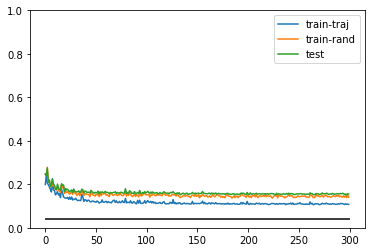

In [14]:
test_scoores = []
train_scoores = []
train_rand_scoores = []
create_path('./error_plots/{}'.format(comment))
for i in range(300):
    ids_rand = np.random.randint(0, 400000, 1064)
    ids = np.arange(0, 1064)*-1
    test_model = DeepPotential().eval()
    test_model.load_state_dict(torch.load(f'{model_path}epoch_{i}', map_location=lambda storage, loc: storage))
    
    prediction = np.squeeze(backtransform(test_model.forward(X_test), Y_min, Y_max).detach().numpy())
    target = np.squeeze(backtransform(Y_test, Y_min, Y_max).detach().numpy())
    test_scoore = np.round(np.mean(np.abs(prediction - target)), 4)
    
    prediction = np.squeeze(backtransform(test_model.forward(X_train[ids]), Y_min, Y_max).detach().numpy())
    target = np.squeeze(backtransform(Y_train[ids], Y_min, Y_max).detach().numpy())
    train_scoore = np.round(np.mean(np.abs(prediction - target)), 4)
    
    prediction = np.squeeze(backtransform(test_model.forward(X_train[ids_rand]), Y_min, Y_max).detach().numpy())
    target = np.squeeze(backtransform(Y_train[ids_rand], Y_min, Y_max).detach().numpy())
    train_rand_scoore = np.round(np.mean(np.abs(prediction - target)), 4)
    
    print('{}:\ttest scoore: {:10.4f}\t\ttrain scoore: {:10.4f}'.format(i, test_scoore, train_scoore))
    test_scoores.append(test_scoore)
    train_scoores.append(train_scoore)
    train_rand_scoores.append(train_rand_scoore)

print('Done')
plt.plot(train_scoores, label='train-traj')
plt.plot(train_rand_scoores, label='train-rand')
plt.plot(test_scoores, label='test')
plt.hlines(0.04, 0, len(train_scoores))
plt.legend()
plt.ylim([0, 1])
plt.savefig('./error_plots/{}/abs_error_{}'.format(comment, int(time.time())))

## Investigate different Results for a Datapoint depending on its Neighbours

In [15]:
ids.shape, ids_rand.shape

((1064,), (1064,))

In [18]:
test_model = DeepPotential().eval()
test_model.load_state_dict(torch.load(f'{model_path}epoch_{199}', map_location=lambda storage, loc: storage))

In [19]:
result_small = test_model(X_train[:1000])
result_large = test_model(X_train[:10000])[:1000]
print(result_small - result_large)

tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 

In [ ]:
test_model = DeepPotential()
test_model.load_state_dict(torch.load(f'ModelCheckpoints/c7o2h10/epoch_{i-1}', map_location=lambda storage, loc: storage))    
single_scoores = []
for data_point in range(X_train.shape[0]):
    test_result = np.squeeze(backtransform(test_model(X_train[data_point].reshape(1, 19, 72)), Y_min, Y_max).detach().numpy())
    val_result = np.squeeze(backtransform(Y_train[data_point].reshape(1, 19, 72), Y_min, Y_max).detach().numpy())
    train_scoore = np.round(np.mean(np.abs(test_result - val_result)), 4)
    single_scoores.append(train_scoore)
    print(data_point/X_train.shape, )

In [ ]:
X_train[0].reshape(1, 19, 72).shape

In [ ]:
test_result = np.squeeze(backtransform(test_model(X_train[ids_rand]), Y_min, Y_max).detach().numpy())
val_result = np.squeeze(backtransform(Y_train[ids_rand], Y_min, Y_max).detach().numpy())
scoore = np.mean(np.abs(test_result - val_result))

In [ ]:
test_result[:15]

In [ ]:
val_result[:15]

In [ ]:
scoore

In [ ]:
test_result = np.squeeze(backtransform(test_model(X_test), Y_min, Y_max).detach().numpy())
val_result = np.squeeze(backtransform(Y_test, Y_min, Y_max).detach().numpy())

In [ ]:
test_diff = np.abs(test_result - val_result)

In [ ]:
sort = val_result.argsort()

In [ ]:
plt.plot(test_diff[sort], '.',markevery=20)

In [ ]:
test_result[:100]

In [ ]:
val_result[:100]

# Testing

## Test normalize function:

In [ ]:
Y_load = np.load(label_path) * -1
Y_normed, Y_min, Y_max = normalize(Y_load)
Y_back = backtransform(Y_normed, Y_min, Y_max)
np.testing.assert_array_almost_equal(Y_back, Y_load)

In [ ]:
x = np.arange(0, 9).reshape(3, 3)

In [ ]:
x

In [ ]:
shuffle = np.arange(0, 3)
np.random.shuffle(shuffle)
shuffle

In [ ]:
x[shuffle]